In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy.ndimage as ndi
import pickle
import pandas as pd

from pathlib import Path
import shutil

from src.data.paths import project_dir
from src.data.analysis import read_tiff_img, Circle, create_circular_mask
from src.data.detector import DetectorDataCollection, DetectorData, DetectorImage

/tmp/ipykernel_294261/591322904.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# local paths
base_path = project_dir / 'data' / 'raw'
#base_path = Path.home() / 'OneDrive - ifj.edu.pl' / 'Projects' / 'MB_foils'

base_path.exists()

True

In [3]:
output_path = project_dir / 'data' / 'interim' / '2025-03-27' / 'proton_profiles.pkl'

In [4]:
with open(output_path, 'rb') as f:
    data = pickle.load(f)
Z_plot = data['Z_plot']
X_plot = data['X_plot']
Y_plot = data['Y_plot']
y_label_roi = data['y_label_roi']
original_ids_for_profiles = data['original_ids_for_profiles']

In [5]:
# subtrack background
Z_plot -= 490

# use calibration from Co60, where 4500 == 60 Gy
Z_plot /= 4500
Z_plot *= 60

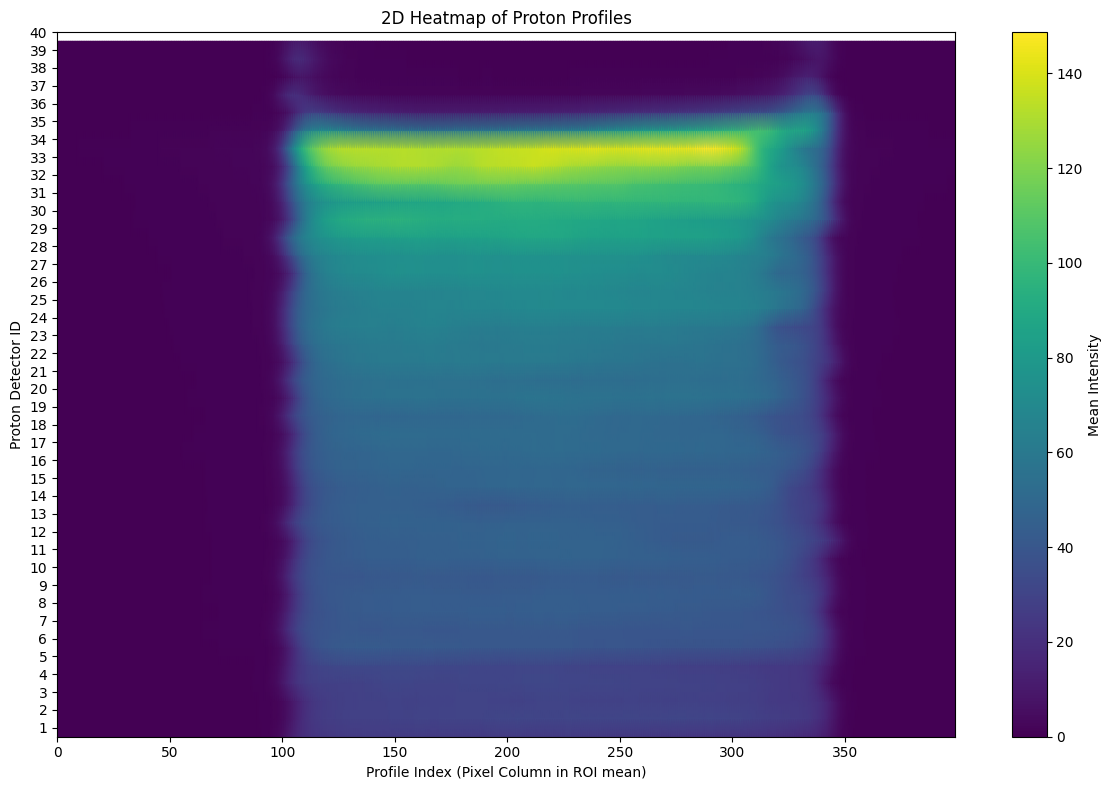

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
    
# Use pcolormesh for heatmap
heatmap = ax.pcolormesh(Z_plot, cmap='viridis', shading='gouraud') # 'viridis' is a good default colormap

# Set labels and title
ax.set_xlabel('Profile Index (Pixel Column in ROI mean)')
ax.set_ylabel(y_label_roi)  # Use the y_label determined in the ROI preparation step
ax.set_title('2D Heatmap of Proton Profiles')

# Add a color bar
cbar = fig.colorbar(heatmap, label='Mean Intensity')

ax.set_yticks(np.arange(len(original_ids_for_profiles)) + 0.5) # Center ticks
ax.set_yticklabels(original_ids_for_profiles)

plt.tight_layout()

In [7]:
df_pos = pd.DataFrame({
    'det_no' : original_ids_for_profiles,
})
df_pos['det_thickness'] = 1.05 * 0.44
df_pos['det_begin'] = df_pos.det_thickness.cumsum().shift(fill_value=0)
# increase det_begin for all detectors with det_no > 5 by 4
df_pos.loc[df_pos.det_no > 5, 'det_begin'] += (2.19 + 2.19 + 2.26 + 2.24 + 2.5)*1.15
df_pos['det_end'] = df_pos.det_begin + df_pos.det_thickness
df_pos['det_mid'] = df_pos.det_begin + df_pos.det_thickness / 2
df_pos

,det_no,det_thickness,det_begin,det_end,det_mid
0,1,0.462,0.000,0.462,0.231
1,2,0.462,0.462,0.924,0.693
2,3,0.462,0.924,1.386,1.155
3,4,0.462,1.386,1.848,1.617
4,5,0.462,1.848,2.310,2.079
5,6,0.462,15.397,15.859,15.628
6,7,0.462,15.859,16.321,16.090
7,8,0.462,16.321,16.783,16.552
8,9,0.462,16.783,17.245,17.014
9,10,0.462,17.245,17.707,17.476


In [8]:
# --- Conversion Factor ---
px_to_mm = 0.07211249531663806

Text(0, 0.5, 'Detector Position (mm)')

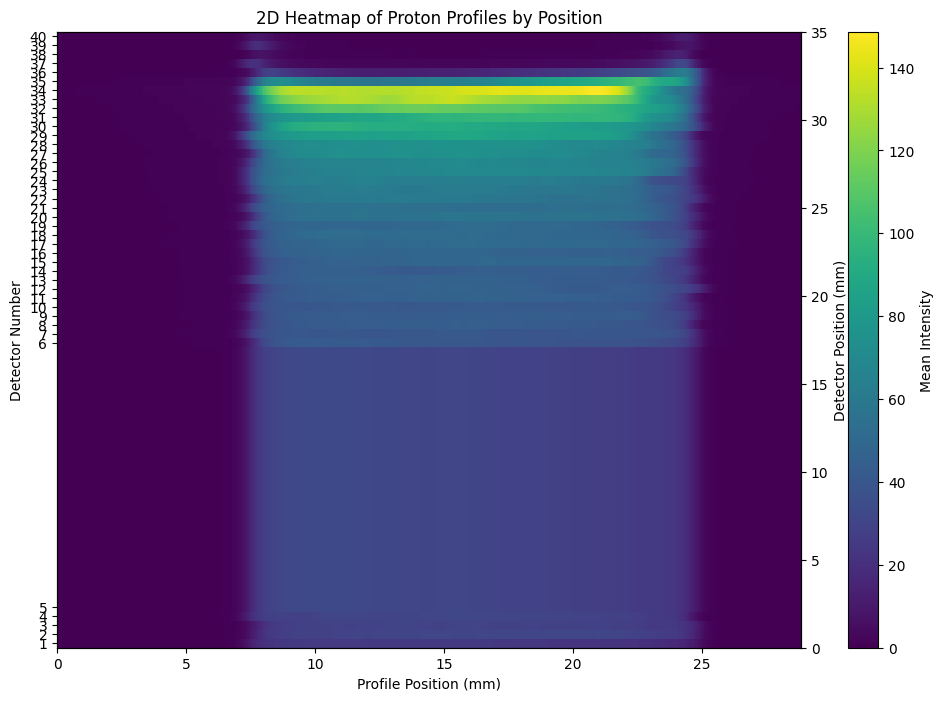

In [9]:
x_edges_pixels = np.arange(Z_plot.shape[1] + 1)
x_edges_mm = x_edges_pixels * px_to_mm  # Apply conversion

# Y coordinates (Detector Position edges)
y_edges = np.concatenate([df_pos['det_begin'].values, [df_pos['det_end'].iloc[-1]]])

# Y tick positions (Detector Midpoints for primary axis)
y_ticks_primary = df_pos['det_mid'].values

# Y tick labels (Detector Numbers for primary axis)
y_tick_labels_primary = df_pos['det_no'].values 

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))
    
# Use pcolormesh with X (in mm) and Y coordinates.
heatmap = ax.pcolormesh(x_edges_mm, y_edges, Z_plot, cmap='viridis', shading='auto') 

# Add a color bar
cbar = fig.colorbar(heatmap, label='Mean Intensity')

# --- Primary Y-axis (Left) ---
ax.set_xlabel('Profile Position (mm)')  # Updated X-axis label
ax.set_ylabel('Detector Number')  
ax.set_title('2D Heatmap of Proton Profiles by Position')
ax.set_yticks(y_ticks_primary)
ax.set_yticklabels(y_tick_labels_primary)

# --- Secondary Y-axis (Right) ---
ax2 = ax.twinx() 
y_min, y_max = ax.get_ylim()
ax2.set_ylim(y_min, y_max) 

# Calculate new uniform ticks every 5mm for the secondary y-axis
tick_start = np.floor(y_min / 5) * 5 
tick_end = np.ceil(y_max / 5) * 5 
new_y_ticks_secondary = np.arange(tick_start, tick_end + 1, 5.0)

ax2.set_yticks(new_y_ticks_secondary)
ax2.set_yticklabels([f"{tick:.0f}" for tick in new_y_ticks_secondary]) 
ax2.set_ylabel('Detector Position (mm)') 


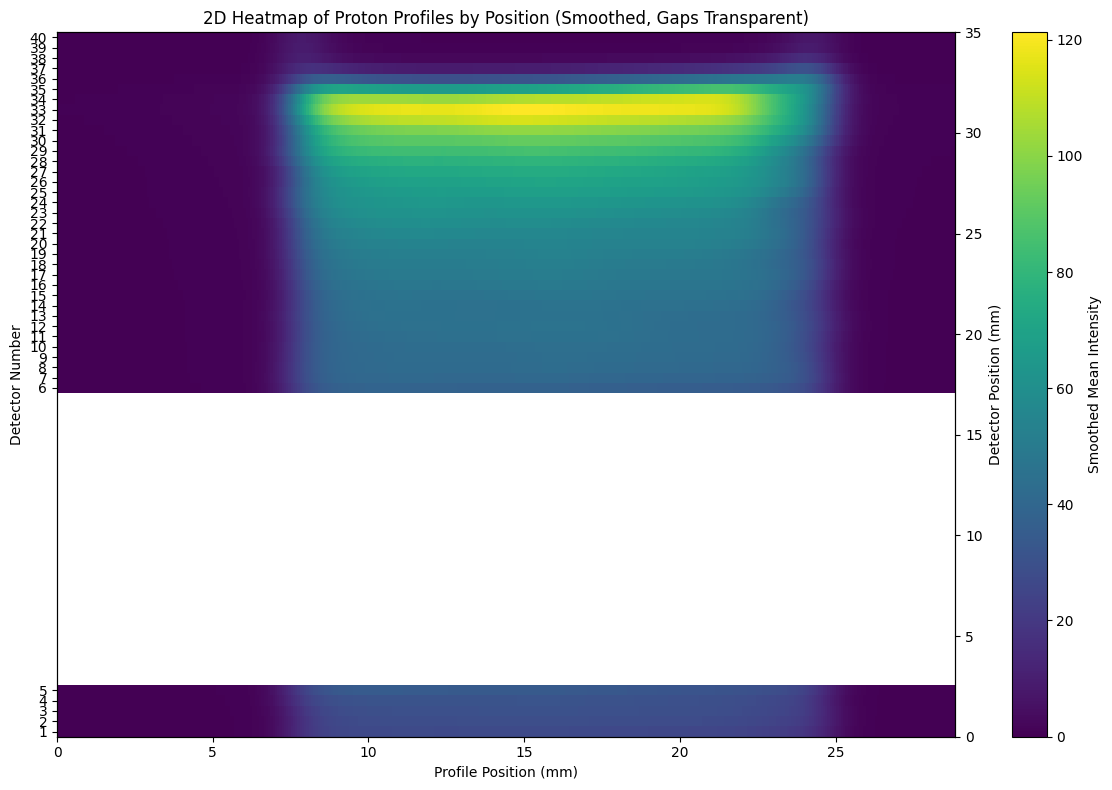

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import copy

# --- Assume df_pos, Z_plot are loaded and px_to_mm is defined ---
# --- Also assume Z_plot and df_pos are aligned and consistent ---

# --- Conversion Factor ---
px_to_mm = 0.07211249531663806

# --- Calculate Sigmas for Gaussian Filter (target = 1 mm) ---
sigma_x = 0.5 / px_to_mm 
avg_det_thick_mm = df_pos['det_thickness'].mean()
sigma_y = 0.5 / avg_det_thick_mm

# --- Apply Gaussian Smoothing ---
Z_smooth = gaussian_filter(Z_plot, sigma=(sigma_y, sigma_x))

# --- Prepare coordinates and labels ---
x_edges_pixels = np.arange(Z_plot.shape[1] + 1)
x_edges_mm = x_edges_pixels * px_to_mm 

# --- Build Y_edges and Z_data including gaps ---
y_edges_gaps = []
Z_list = []
nan_row = np.full(Z_smooth.shape[1], np.nan) # Row of NaNs

for i in range(len(df_pos)):
    y_edges_gaps.append(df_pos['det_begin'].iloc[i])
    Z_list.append(Z_smooth[i, :])

    gap_start = df_pos['det_end'].iloc[i]
    
    # Check for a gap *after* this detector (if not the last one)
    if i < len(df_pos) - 1:
        gap_end = df_pos['det_begin'].iloc[i+1]
        if gap_end > gap_start: # If a gap exists
            y_edges_gaps.append(gap_start) # End of current detector
            Z_list.append(nan_row)       # Add NaN row for the gap
            # The begin of the next detector will be added in the next iteration

# Add the end edge of the *last* detector
y_edges_gaps.append(df_pos['det_end'].iloc[-1])

# Convert to numpy arrays
Z_gaps = np.array(Z_list)
y_edges_gaps = np.array(y_edges_gaps)

# Y tick positions (Detector Midpoints for primary axis)
y_ticks_primary = df_pos['det_mid'].values
y_tick_labels_primary = df_pos['det_no'].values 

# --- Setup Colormap to handle NaNs ---
cmap = copy.copy(plt.get_cmap('viridis'))
cmap.set_bad(color='white', alpha=0) # Set NaN color to transparent

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 8))
    
# Use pcolormesh with gaps data and custom colormap
heatmap = ax.pcolormesh(x_edges_mm, y_edges_gaps, Z_gaps, cmap=cmap, shading='auto') 

# Add a color bar
cbar = fig.colorbar(heatmap, label='Smoothed Mean Intensity')

# --- Primary Y-axis (Left) ---
ax.set_xlabel('Profile Position (mm)')  
ax.set_ylabel('Detector Number')  
ax.set_title('2D Heatmap of Proton Profiles by Position (Smoothed, Gaps Transparent)') 
ax.set_yticks(y_ticks_primary)
ax.set_yticklabels(y_tick_labels_primary)

# --- Secondary Y-axis (Right) ---
ax2 = ax.twinx() 
y_min, y_max = ax.get_ylim()
ax2.set_ylim(y_min, y_max) 

# Calculate and set uniform ticks every 5mm
tick_start = np.floor(y_min / 5) * 5 
tick_end = np.ceil(y_max / 5) * 5 
new_y_ticks_secondary = np.arange(tick_start, tick_end + 1, 5.0)

ax2.set_yticks(new_y_ticks_secondary)
ax2.set_yticklabels([f"{tick:.0f}" for tick in new_y_ticks_secondary]) 
ax2.set_ylabel('Detector Position (mm)') 

plt.tight_layout()

In [12]:
# --- Conversion Factor ---
px_to_mm = 0.07211249531663806

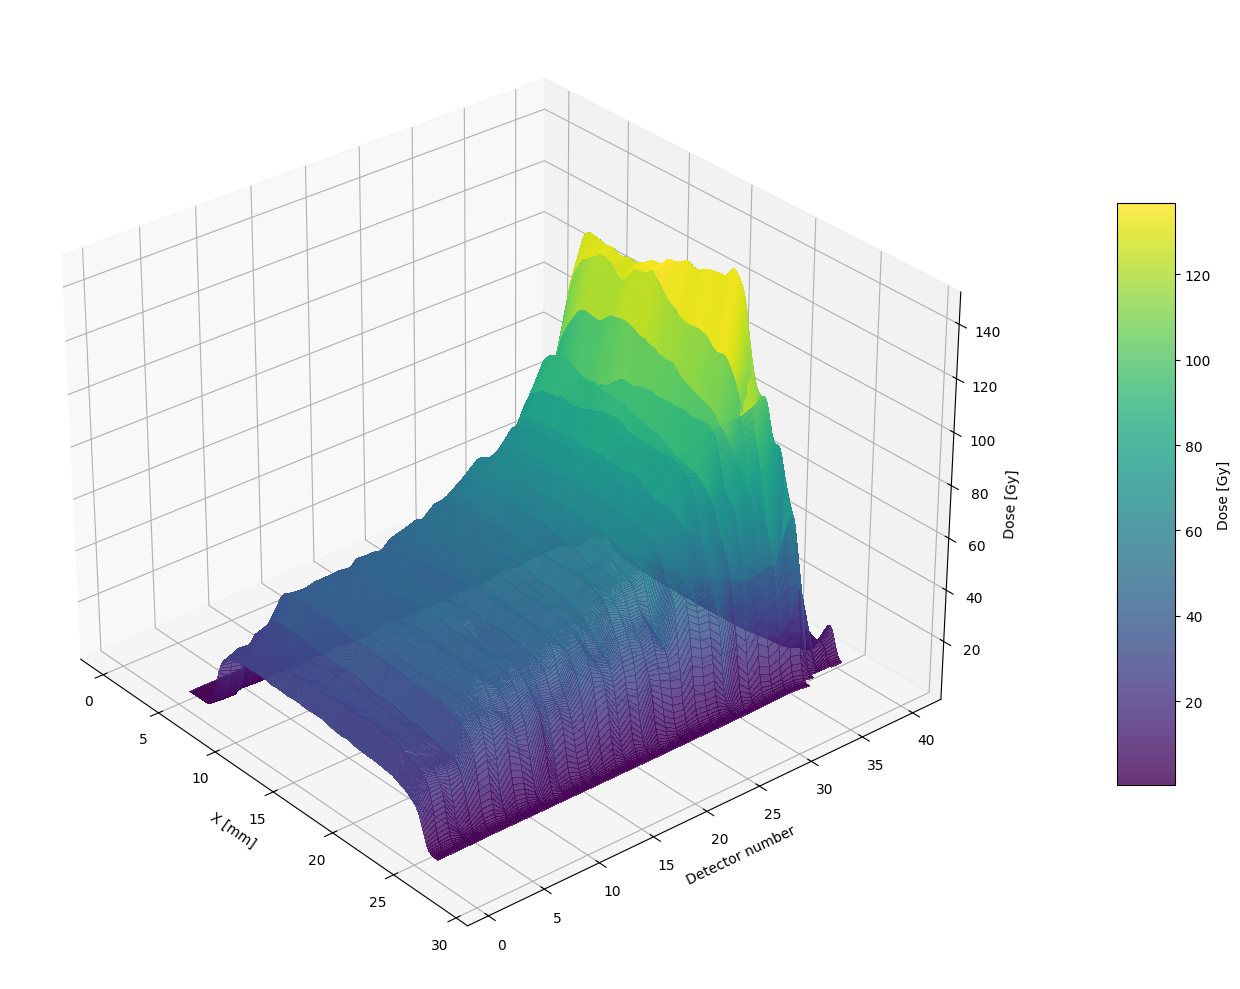

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy


# --- Use Z_plot and clip (NO SMOOTHING as per new code) ---
Z_data = np.clip(Z_plot, 0, None)  # Ensure no negative values for intensity

# replace zero values with NaN for better visualization
Z_data[Z_data < 0.3] = np.nan  # Replace zero values with NaN for better visualization

# --- Prepare coordinates for 3D plot ---
# Calculate X centers in mm
x_edges_pixels = np.arange(Z_data.shape[1] + 1)
x_edges_mm = x_edges_pixels * px_to_mm 
x_centers_mm = (x_edges_mm[:-1] + x_edges_mm[1:]) / 2

# set np.nan for Z_data where x is less than 4 mm
Z_data[:, x_centers_mm < 5] = np.nan  # Set NaN for X centers less than 4 mm
Z_data[:, x_centers_mm > 26] = np.nan  # Set NaN for X centers greater than 26 mm


# Use detector IDs for Y centers
# Ensure 'det_no' exists in your df_pos DataFrame
y_ids = df_pos['det_no'].values

# Create meshgrid for X and Y using detector IDs
X_grid, Y_grid = np.meshgrid(x_centers_mm, y_ids)

# --- 3D Plotting ---
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface using X_grid, Y_grid (with IDs), and Z_data
surf = ax.plot_surface(X_grid, Y_grid, Z_data, cmap='viridis', 
                       rstride=1, cstride=1,
                       alpha=0.8,
                       edgecolor='none', antialiased=False)

# Set labels and title
ax.set_xlabel('X [mm]')  # Updated X-axis label
ax.set_ylabel('Detector number')  # Updated Y-axis label
ax.set_zlabel('Dose [Gy]') # Updated Z-axis label
#ax.set_title('3D Surface Plot of Proton Profiles by Detector ID') # Updated title

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.6, aspect=10, label='Dose [Gy]', pad=0.1)

# Optional: Adjust view angle for better perspective
ax.view_init(elev=30., azim=-40)

plt.tight_layout()

# save the figure as SVG to same folder as the pickle file
output_svg_path = output_path.with_suffix('.svg')
fig.savefig(output_svg_path, format='svg', bbox_inches='tight')

In [35]:
output_svg_path

PosixPath('/home/grzanka/workspace/osl_mb_foils/data/interim/2025-03-27/proton_profiles.svg')